# Hough Transform

The Hough transform is a feature extraction technique used in image analysis, computer vision, and digital image processing. The purpose of the technique is to find imperfect instances of objects within a certain class of shapes by a voting procedure. This voting procedure is carried out in a parameter space, from which object candidates are obtained as local maxima in a so-called accumulator space that is explicitly constructed by the algorithm for computing the Hough transform.

![alt text](ideal.jfif "Title")

Source: Wikipedia 
Image source: Google Images

## Submission

You can code directly in the notebook - no more switching between tabs (Thank us later) 

All submissions will be via Gradescope. If you're completing this assignment in Jupyter Notebook, you must run the `notebook2script.py` file to export your work to a python file. To generate your submission file, run the command 

`python notebook2script.py submission`

and your file will be created under the `submission` directory.

PLEASE DON'T REMOVE THE #export FROM ANY CELL

# Setup

Use the cell below to load the required libraries (You are not allowed to use anything other than cv2 and numpy)

In [1]:
#export
import cv2 #Only to be used for Canny Edge Detector
import numpy as np
from scipy import stats
import test_simple as tests
import sys
np.set_printoptions(threshold=sys.maxsize)
Checker = tests.PS02Test()

Running on Linux/OS X system


# Part 1: Traffic Light [15 points]

In [129]:
#export
def traffic_light_detection(img_in, radii_range):
    """Finds the coordinates of a traffic light image given a radii
    range.
    Use the radii range to find the circles in the traffic light and
    identify which of them represents the yellow light.
    Analyze the states of all three lights and determine whether the
    traffic light is red, yellow, or green. This will be referred to
    as the 'state'.
    It is recommended you use Hough transform to find these circles in
    the image.
    The input image may be just the traffic light with a white
    background or a larger image of a scene containing a traffic
    light.
    Args:
        img_in (numpy.array BGR): image containing a traffic light.
        radii_range (list): range of radii values to search for.
    Returns:
        tuple: 2-element tuple containing:
        coordinates (tuple): traffic light center using the (x, y)
                             convention.
        state (str): traffic light state. A value in {'red', 'yellow',
                     'green'}
        Numpy array: Height x Width matrix of Hough accumulator array  (Height and width from the image)
    """
    threshold = 8.1
    region = 15
    
    medianImg = np.median(img_in)
    edgeImg = cv2.Canny(img_in, int(max(0, 0.66 * medianImg)), int(min(255, 1.33 * medianImg)))
    h, w = edgeImg.shape
    A = np.zeros((len(radii_range), h, w))
    B = np.zeros((h, w))
    
    angles = np.arange(360) * np.pi / 180
    edges = np.argwhere(edgeImg)
    for i, r in enumerate(radii_range):
        c = np.zeros((2*r, 2*r))
        cx, cy = r, r
        for angle in angles:
            dx = int(np.round(r*np.cos(angle)))
            dy = int(np.round(r*np.sin(angle)))
            c[cx + dx - 1, cy + dy - 1] = 1
        constant = np.argwhere(c).shape[0]
#         print(constant)
        for ex, ey in edges:
            for dx in range(-r, r):
                for dy in range(-r, r):
                    x, y = ex + dx, ey + dy
                    if x >= 0 and x < h and y >= 0 and y < w:
                        A[i][x][y] += c[dx + r][dy + r]
        A[i][A[i] < threshold * constant / r] = 0
        
    for r, x, y in np.argwhere(A):
        temp = A[:, x - region: x + region, y - region: y + region]
        try:
            i, j, k = np.unravel_index(np.argmax(temp), temp.shape)
        except:
            continue
        B[x - region + j][y - region + k] = radii_range[i]
        
    circleCoords = np.argwhere(B)
    cy = circleCoords[:, 0]
    cx = circleCoords[:, 1]
    maxv = 0
    
    for (x, y) in zip(cx, cy):
        r = int(B[y][x])
#         print(x, y, r)
        circle = img_in[y - r: y + r, x - r: x + r, :]
        pos = np.unravel_index(np.argmax(circle), circle.shape)
        v = np.max(circle) * 100
#         print(pos, v)
        if v > maxv:
            maxv = v
            c = pos[2]
            
    status = 'red' if c == 2 else ('green' if c == 1 and maxv == 25500 else 'yellow')
    
    return ((cx[1], cy[1]), status), B
    

## Run the tests below to verify your code

((267, 342), 'red')


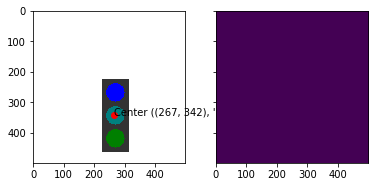

UnitTest testTrafficLightBlank passed successfully!
((267, 342), 'red')


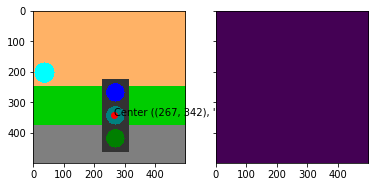

UnitTest testTrafficLightScene passed successfully!


In [130]:
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST - COMMENT/UNCOMMENT TESTS WHILE DEBUGGING ######
Checker.testTrafficLightBlank(traffic_light_detection)
Checker.testTrafficLightScene(traffic_light_detection)

#Don't worry about the color reversal in your plots
################ END OF LOCAL TEST CODE SECTION ################################################

# Part 2: Traffic Signs one per scene [25 points]

In [143]:
#export
from matplotlib import pyplot as plt
def valid_point(pt, ymax, xmax):
    '''
    @return True/False if pt is with bounds for an xmax by ymax image
    '''
    x, y = pt
    if x <= xmax and x >= 0 and y <= ymax and y >= 0:
        return True
    else:
        return False

def round_tup(tup):
    '''
    @return closest integer for each number in a point for referencing
    a particular pixel in an image
    '''
    x,y = [int(round(num)) for num in tup]
    return (x,y)

def make_line_and_point(img, theta, rho, x, y):
    im_y_max, im_x_max = img.shape
    m = -np.cos(theta) / np.sin(theta)
    b = rho / np.sin(theta)
    # possible intersections on image edges
    left = (0, b)
    right = (im_x_max, im_x_max * m + b)
    top = (-b / m, 0)
    bottom = ((im_y_max - b) / m, im_y_max)

    pts = [pt for pt in [left, right, top, bottom] if valid_point(pt, im_y_max, im_x_max)]
    if len(pts) == 2:
        cv2.line(img, round_tup(pts[0]), round_tup(pts[1]), (255,255,255), 3)
        cv2.circle(img, (x, y), 10, (255,255,255), 3)
    
def yield_sign_detection(img_in):
    """Finds the centroid coordinates of a yield sign in the provided
    image.
    Args:
        img_in (numpy.array BGR): image containing a traffic light.
    Returns:
        (x,y) tuple of coordinates of the center of the yield sign.
        Numpy array: Height x Width matrix of Hough accumulator array  (Height and width from the image)
    """
    medianImg = np.median(img_in)
    edgeImg = cv2.Canny(img_in, int(max(0, 0.66 * medianImg)), int(min(255, 1.33 * medianImg)))
    h, w = edgeImg.shape
    
    theta = np.linspace(-90.0, 0.0, int(np.ceil(90.0) + 1.0))
    theta = np.concatenate((theta, -theta[len(theta)-2::-1]))
#     print(theta)
    
    D = np.sqrt((h - 1)**2 + (w - 1)**2)
    q = np.ceil(D)
    nrho = 2*q + 1
    rho = np.linspace(-q, q, int(nrho))
#     print(rho)
    H = np.zeros((len(rho), len(theta)))
    for rowIdx in range(h):
        for colIdx in range(w):
            if edgeImg[rowIdx, colIdx]:
                for thIdx in range(len(theta)):
                    rhoVal = colIdx*np.cos(theta[thIdx]*np.pi/180.0) + \
                      rowIdx*np.sin(theta[thIdx]*np.pi/180)
                    rhoIdx = np.nonzero(np.abs(rho-rhoVal) == np.min(np.abs(rho-rhoVal)))[0]
                    H[rhoIdx[0], thIdx] += 1
    
    region = 15
    cH = H.copy()
    for x, y in np.argwhere(H):
        temp = H[x - region: x + region, y - region: y + region]
        try:
            i, j = np.unravel_index(np.argmax(temp), temp.shape)
        except:
            continue
        cH[x - region + i][y - region + j] = np.max(temp)
    H = cH
                    
    flat = list(set(np.hstack(H)))
    flat_sorted = sorted(flat, key = lambda n: -n)
    coords_sorted = [(np.argwhere(H == acc_value)) for acc_value in flat_sorted]
    rho_theta = []
    x_y = []
    for coords_for_val_idx in range(0, len(coords_sorted), 1):
        coords_for_val = coords_sorted[coords_for_val_idx]
        for i in range(0, len(coords_for_val), 1):
            n,m = coords_for_val[i] # n by m matrix
            r = rho[n]
            t = theta[m]
            rho_theta.append([r, t])
            x_y.append([m, n]) # just to unnest and reorder coords_sorted
            
#     print(rho_theta)
#     print(x_y)

    dl = set()
    i = 0
    while(len(dl) < 3 and i < len(rho_theta)):
        point = rho_theta[i]
        rho = np.abs(point[0])
        theta = point[1] + 180 if point[1] < 0 else point[1]
        dl.add((rho, theta))
        i += 1
    
    print(dl)
    
    dl = list(dl)
    rho1, theta1 = dl[0]
    rho2, theta2 = dl[1]
    rho3, theta3 = dl[2]
    
    theta1 = theta1 - 180 if theta1 > 90 else theta1
    theta2 = theta2 - 180 if theta2 > 90 else theta2
    theta3 = theta3 - 180 if theta3 > 90 else theta3
    
    theta1 *= np.pi / 180
    theta2 *= np.pi / 180
    theta3 *= np.pi / 180
    
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta3), np.sin(theta3)]
    ])
    b = np.array([[rho1], [rho3]])
    x1, y1 = np.linalg.solve(A, b)
    x1, y1 = int(np.round(x1)), int(np.round(y1))
    
    A = np.array([
        [np.cos(theta3), np.sin(theta3)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho3], [rho2]])
    x2, y2 = np.linalg.solve(A, b)
    x2, y2 = int(np.round(x2)), int(np.round(y2))
    
#     print(x0, y0)
#     print(x1, y1)
#     print(x2, y2)
#     print((x0 + x1 + x2) / 3, (y0 + y1 + y2) / 3)
    
#     cimg = edgeImg.copy()
#     make_line_and_point(cimg, theta1, rho1, x0, y0)
#     make_line_and_point(cimg, theta2, rho3, x1, y1)
#     make_line_and_point(cimg, theta3, rho3, x2, y2)
    
#     plt.subplot(141),plt.imshow(edgeImg)
#     plt.title('Original Image'), plt.xticks([]), plt.yticks([])
#     plt.subplot(142),plt.imshow(cimg)
#     plt.title('Detected Lines'), plt.xticks([]), plt.yticks([])
    
#     plt.show()
    
    return ((x0 + x1 + x2) / 3, (y0 + y1 + y2) / 3), H

In [306]:
#export
def stop_sign_detection(img_in):
    """Finds the centroid coordinates of a stop sign in the provided
    image.
    Args:
        img_in (numpy.array BGR): image containing a traffic light.
    Returns:
        (x,y) tuple of the coordinates of the center of the stop sign.
        Numpy array: Height x Width matrix of Hough accumulator array  (Height and width from the image)
    """
    threshold = 8.1
    region = 15
    radii_range = [15]
    
    medianImg = np.median(img_in)
    edgeImg = cv2.Canny(img_in, int(max(0, 0.66 * medianImg)), int(min(255, 1.33 * medianImg)))
    h, w = edgeImg.shape
    A = np.zeros((len(radii_range), h, w))
    B = np.zeros((h, w))
    
    angles = np.arange(360) * np.pi / 180
    edges = np.argwhere(edgeImg)
    for i, r in enumerate(radii_range):
        c = np.zeros((2*r, 2*r))
        cx, cy = r, r
        for angle in angles:
            dx = int(np.round(r*np.cos(angle)))
            dy = int(np.round(r*np.sin(angle)))
            c[cx + dx - 1, cy + dy - 1] = 1
        constant = np.argwhere(c).shape[0]
#         print(constant)
        for ex, ey in edges:
            for dx in range(-r, r):
                for dy in range(-r, r):
                    x, y = ex + dx, ey + dy
                    if x >= 0 and x < h and y >= 0 and y < w:
                        A[i][x][y] += c[dx + r][dy + r]
#         A[i][A[i] < threshold * constant / r] = 0
        
    for r, x, y in np.argwhere(A):
        temp = A[:, x - region: x + region, y - region: y + region]
        try:
            i, j, k = np.unravel_index(np.argmax(temp), temp.shape)
        except:
            continue
        B[x - region + j][y - region + k] = radii_range[i]
        
    circleCoords = np.argwhere(B)
    cy = circleCoords[:, 0]
    cx = circleCoords[:, 1]
    
    return (np.average(cx), np.average(cy)),  B
    

In [220]:
#export
def warning_sign_detection(img_in):
    """Finds the centroid coordinates of a warning sign in the
    provided image.
    Args:
        img_in (numpy.array BGR): image containing a traffic light.
    Returns:
        (x,y) tuple of the coordinates of the center of the sign.
        Numpy array: Height x Width matrix of Hough accumulator array  (Height and width from the image)
    """
    edgeImg = cv2.Canny(img_in, 50, 200)
    h, w = edgeImg.shape
    
    theta = np.linspace(-90.0, 0.0, int(np.ceil(90.0) + 1.0))
    theta = np.concatenate((theta, -theta[len(theta)-2::-1]))
#     print(theta)
    
    D = np.sqrt((h - 1)**2 + (w - 1)**2)
    q = np.ceil(D)
    nrho = 2*q + 1
    rho = np.linspace(-q, q, int(nrho))
#     print(rho)
    H = np.zeros((len(rho), len(theta)))
    for rowIdx in range(h):
        for colIdx in range(w):
            if edgeImg[rowIdx, colIdx]:
                for thIdx in range(len(theta)):
                    rhoVal = colIdx*np.cos(theta[thIdx]*np.pi/180.0) + \
                      rowIdx*np.sin(theta[thIdx]*np.pi/180)
                    rhoIdx = np.nonzero(np.abs(rho-rhoVal) == np.min(np.abs(rho-rhoVal)))[0]
                    H[rhoIdx[0], thIdx] += 1
    
    region = 50
    cH = np.zeros_like(H)
    for x, y in np.argwhere(H):
        temp = H[x - region: x + region, y - region: y + region]
        try:
            i, j = np.unravel_index(np.argmax(temp), temp.shape)
        except:
            continue
        cH[x - region + i][y - region + j] = np.max(temp)
    H = cH
                    
    flat = list(set(np.hstack(H)))
    flat_sorted = sorted(flat, key = lambda n: -n)
    coords_sorted = [(np.argwhere(H == acc_value)) for acc_value in flat_sorted]
    rho_theta = []
    x_y = []
    for coords_for_val_idx in range(0, len(coords_sorted), 1):
        coords_for_val = coords_sorted[coords_for_val_idx]
        for i in range(0, len(coords_for_val), 1):
            n,m = coords_for_val[i] # n by m matrix
            r = rho[n]
            t = theta[m]
            rho_theta.append([r, t])
            x_y.append([m, n]) # just to unnest and reorder coords_sorted
            
#     print(rho_theta)
#     print(x_y)

    dl = set()
    i = 0
    while(len(dl) < 4 and i < len(rho_theta)):
        point = rho_theta[i]
        rho = np.abs(point[0])
        theta = point[1] + 180 if point[1] < 0 else point[1]
        add = True if theta == 45 or theta == 135 else False
        for r, _ in dl:
            if abs(rho - r) < 10:
                add = False
        if add:
            dl.add((rho, theta))
        i += 1
    
    dl = sorted(dl, key = lambda t: t[1])
    dl = list(dl)
    dl[3] = (dl[2][0] - abs(dl[1][0] - dl[0][0]), 135)
    print(dl)
    inter = []
    cx, cy = 0, 0
    cimg = edgeImg.copy()
    for j in range(2):
        for i in range(2):
            rho1, theta1 = dl[j]
            rho2, theta2 = dl[i + 2]

            theta1 = theta1 - 180 if theta1 > 90 else theta1
            theta2 = theta2 - 180 if theta2 > 90 else theta2

            theta1 *= np.pi / 180
            theta2 *= np.pi / 180

            A = np.array([
                [np.cos(theta1), np.sin(theta1)],
                [np.cos(theta2), np.sin(theta2)]
            ])
            b = np.array([[rho1], [rho2]])
            x0, y0 = np.linalg.solve(A, b)
            x0, y0 = int(np.round(x0)), int(np.round(y0))
            inter.append((x0, y0))
            cx += x0 / 4
            cy += y0 / 4
            make_line_and_point(cimg, theta1, rho1, x0, y0)

    plt.subplot(141),plt.imshow(img_in)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(142),plt.imshow(edgeImg)
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(143),plt.imshow(cimg)
    plt.title('Detected Lines'), plt.xticks([]), plt.yticks([])
    
    plt.show()
    
    return (cx, cy), H

In [296]:
#export
def construction_sign_detection(img_in):
    """Finds the centroid coordinates of a construction sign in the
    provided image.
    Args:
        img_in (numpy.array BGR): image containing a traffic light.
    Returns:
        (x,y) tuple of the coordinates of the center of the sign.
        Numpy array: Height x Width matrix of Hough accumulator array  (Height and width from the image)
    """
    edgeImg = cv2.Canny(img_in, 50, 200)
    h, w = edgeImg.shape
    
    theta = np.linspace(-90.0, 0.0, int(np.ceil(90.0) + 1.0))
    theta = np.concatenate((theta, -theta[len(theta)-2::-1]))
#     print(theta)
    
    D = np.sqrt((h - 1)**2 + (w - 1)**2)
    q = np.ceil(D)
    nrho = 2*q + 1
    rho = np.linspace(-q, q, int(nrho))
#     print(rho)
    H = np.zeros((len(rho), len(theta)))
    for rowIdx in range(h):
        for colIdx in range(w):
            if edgeImg[rowIdx, colIdx]:
                for thIdx in range(len(theta)):
                    rhoVal = colIdx*np.cos(theta[thIdx]*np.pi/180.0) + \
                      rowIdx*np.sin(theta[thIdx]*np.pi/180)
                    rhoIdx = np.nonzero(np.abs(rho-rhoVal) == np.min(np.abs(rho-rhoVal)))[0]
                    H[rhoIdx[0], thIdx] += 1
    
    region = 50
    cH = np.zeros_like(H)
    for x, y in np.argwhere(H):
        temp = H[x - region: x + region, y - region: y + region]
        try:
            i, j = np.unravel_index(np.argmax(temp), temp.shape)
        except:
            continue
        cH[x - region + i][y - region + j] = np.max(temp)
    H = cH
                    
    flat = list(set(np.hstack(H)))
    flat_sorted = sorted(flat, key = lambda n: -n)
    coords_sorted = [(np.argwhere(H == acc_value)) for acc_value in flat_sorted]
    rho_theta = []
    x_y = []
    for coords_for_val_idx in range(0, len(coords_sorted), 1):
        coords_for_val = coords_sorted[coords_for_val_idx]
        for i in range(0, len(coords_for_val), 1):
            n,m = coords_for_val[i] # n by m matrix
            r = rho[n]
            t = theta[m]
            rho_theta.append([r, t])
            x_y.append([m, n]) # just to unnest and reorder coords_sorted
            
#     print(rho_theta)
#     print(x_y)

    dl = set()
    i = 0
    while(len(dl) < 4 and i < len(rho_theta)):
        point = rho_theta[i]
        rho = np.abs(point[0])
        theta = point[1] + 180 if point[1] < 0 else point[1]
        add = True if theta == 45 or theta == 135 else False
        for r, _ in dl:
            if abs(rho - r) < 10:
                add = False
        if add:
            dl.add((rho, theta))
        i += 1
    
    dl = sorted(dl, key = lambda t: t[1])
    dl = list(dl)
    dl[3] = (dl[2][0] - abs(dl[1][0] - dl[0][0]), 135)
    print(dl)
    inter = []
    cx, cy = 0, 0
    cimg = edgeImg.copy()
    for j in range(2):
        for i in range(2):
            rho1, theta1 = dl[j]
            rho2, theta2 = dl[i + 2]

            theta1 = theta1 - 180 if theta1 > 90 else theta1
            theta2 = theta2 - 180 if theta2 > 90 else theta2

            theta1 *= np.pi / 180
            theta2 *= np.pi / 180

            A = np.array([
                [np.cos(theta1), np.sin(theta1)],
                [np.cos(theta2), np.sin(theta2)]
            ])
            b = np.array([[rho1], [rho2]])
            x0, y0 = np.linalg.solve(A, b)
            x0, y0 = int(np.round(x0)), int(np.round(y0))
            inter.append((x0, y0))
            cx += x0 / 4
            cy += y0 / 4
            make_line_and_point(cimg, theta1, rho1, x0, y0)

    plt.subplot(141),plt.imshow(img_in)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(142),plt.imshow(edgeImg)
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(143),plt.imshow(cimg)
    plt.title('Detected Lines'), plt.xticks([]), plt.yticks([])
    
    plt.show()
    
    return (cx, cy), H

In [264]:
#export
def do_not_enter_sign_detection(img_in):
    """Find the centroid coordinates of a do not enter sign in the
    provided image.
    Args:
        img_in (numpy.array BGR): image containing a traffic light.
    Returns:
        (x,y) typle of the coordinates of the center of the sign.
        Numpy array: Height x Width matrix of Hough accumulator array  (Height and width from the image)
    """
    threshold = 8.1
    region = 15
    radii_range = [15]
    
    medianImg = np.median(img_in)
    edgeImg = cv2.Canny(img_in, int(max(0, 0.66 * medianImg)), int(min(255, 1.33 * medianImg)))
    h, w = edgeImg.shape
    A = np.zeros((len(radii_range), h, w))
    B = np.zeros((h, w))
    
    angles = np.arange(360) * np.pi / 180
    edges = np.argwhere(edgeImg)
    for i, r in enumerate(radii_range):
        c = np.zeros((2*r, 2*r))
        cx, cy = r, r
        for angle in angles:
            dx = int(np.round(r*np.cos(angle)))
            dy = int(np.round(r*np.sin(angle)))
            c[cx + dx - 1, cy + dy - 1] = 1
        constant = np.argwhere(c).shape[0]
#         print(constant)
        for ex, ey in edges:
            for dx in range(-r, r):
                for dy in range(-r, r):
                    x, y = ex + dx, ey + dy
                    if x >= 0 and x < h and y >= 0 and y < w:
                        A[i][x][y] += c[dx + r][dy + r]
#         A[i][A[i] < threshold * constant / r] = 0
        
    for r, x, y in np.argwhere(A):
        temp = A[:, x - region: x + region, y - region: y + region]
        try:
            i, j, k = np.unravel_index(np.argmax(temp), temp.shape)
        except:
            continue
        B[x - region + j][y - region + k] = radii_range[i]
        
    circleCoords = np.argwhere(B)
#     print(circleCoords)
    cy = circleCoords[:, 0]
    cx = circleCoords[:, 1]
    
    return (np.average(cx), np.average(cy)), B

## Run the tests below to verify your code and generate output

(274.0248447204969, 270.14285714285717)


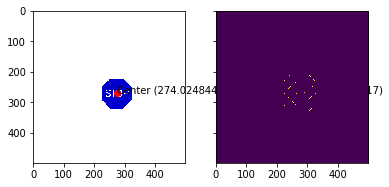

UnitTest testStopSignBlank passed successfully!
[(420.0, 45.0), (352.0, 45.0), (35.0, 135.0), (-33.0, 135)]


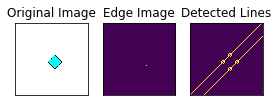

(274.0, 272.0)


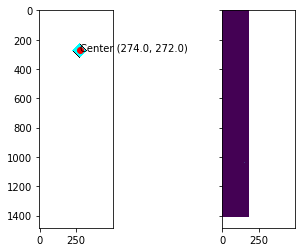

UnitTest testWarningSignBlank passed successfully!
[(420.0, 45.0), (352.0, 45.0), (35.0, 135.0), (-33.0, 135)]


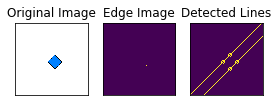

(274.0, 272.0)


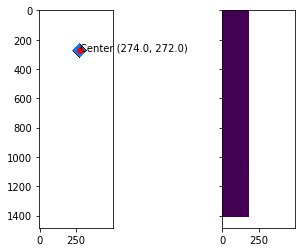

UnitTest testConstructionSignBlank passed successfully!
(272.24468085106383, 274.40425531914894)


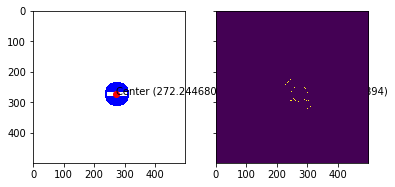

UnitTest testDoNotEnterSignBlank passed successfully!
{(81.0, 150.0), (223.0, 90.0), (406.0, 30.0)}
222 223
281 325
340 223
281.0 257.0


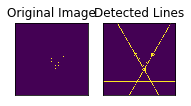

(281.0, 257.0)


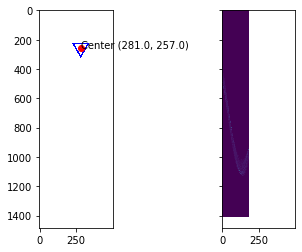

UnitTest testYieldSignBlank passed successfully!


In [307]:
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST - COMMENT/UNCOMMENT TESTS WHILE DEBUGGING ######
Checker.testStopSignBlank(stop_sign_detection)
Checker.testWarningSignBlank(warning_sign_detection)
Checker.testConstructionSignBlank(construction_sign_detection)
Checker.testDoNotEnterSignBlank(do_not_enter_sign_detection)
Checker.testYieldSignBlank(yield_sign_detection)
#Don't worry about the color reversal in your plots
################ END OF LOCAL TEST CODE SECTION ################################################

# Part 3: Multiple signs in a scene [10 points]

In [ ]:
#export
def traffic_sign_detection(img_in):
    """Finds all traffic signs in a synthetic image.
    The image may contain at least one of the following:
    - traffic_light
    - no_entry
    - stop
    - warning
    - yield
    - construction
    Use these names for your output.
    See the instructions document for a visual definition of each
    sign.
    (Hint: Use all the functions defined above)
    Args:
        img_in (numpy.array BGR): input image containing at least one
                              traffic sign.
    Returns:
        dict: dictionary containing only the signs present in the
              image along with their respective centroid coordinates
              as tuples.
              For example: {'stop': (1, 3), 'yield': (4, 11)}
              These are just example values and may not represent a
              valid scene.
    """
    

## Run the tests below to verify your code and generate output

In [ ]:
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST - COMMENT/UNCOMMENT TESTS WHILE DEBUGGING ######
Checker.testTrafficSignScene(traffic_sign_detection)
#Don't worry about the color reversal in your plots
################ END OF LOCAL TEST CODE SECTION ################################################

# Part 4: Extra Credit for CS 4476/ Regular section for CS 6476 [20 points]

Let's move on to the real world because you are not in a simulation. Don't believe Elon Musk.

In [25]:
#export
def detectCircles(im, radius, useGradient = False):
    """
    Args:
        im (numpy.array RGB):the input image
        radius : specifies the radius of the circle 
        useGradient: a flag that allows the user to optionally exploit the gradient direction measured at the edgepoints.
    (Caution: Your x,y maybe swapped)
    Returns:
        Numpy array: N x 2 matrix in which each row lists the (x,y) position of a detectedcircles’ center
        Numpy array: Height x Width matrix of Hough accumulator array  (Height and width from the image)
    
    """
    threshold = 4
    region = 50
    radii_range = [radius]
    
    medianImg = np.median(im)
    edgeImg = cv2.Canny(im, int(max(0, 0.66 * medianImg)), int(min(255, 1.33 * medianImg)))
    h, w = edgeImg.shape
    A = np.zeros((len(radii_range), h, w))
    B = np.zeros((h, w))
    
    angles = np.arange(360) * np.pi / 180
    edges = np.argwhere(edgeImg)
    for i, r in enumerate(radii_range):
#         print(r)
        c = np.zeros((2*r, 2*r))
        cx, cy = r, r
        for angle in angles:
            dx = int(np.round(r*np.cos(angle)))
            dy = int(np.round(r*np.sin(angle)))
            c[cx + dx - 1, cy + dy - 1] = 1
        constant = np.argwhere(c).shape[0]
        print(constant)
        for ex, ey in edges:
            for dx in range(-r, r):
                for dy in range(-r, r):
                    x, y = ex + dx, ey + dy
                    if x >= 0 and x < h and y >= 0 and y < w:
                        A[i][x][y] += c[dx + r][dy + r]
        A[i][A[i] < threshold * constant / r] = 0
        
    for r, x, y in np.argwhere(A):
        temp = A[:, x - region: x + region, y - region: y + region]
        try:
            i, j, k = np.unravel_index(np.argmax(temp), temp.shape)
        except:
            continue
        B[x - region + j][y - region + k] = radii_range[i]
        
    print(A[0][74][235])
    print(A[0][235][74])
    flat = list(set(np.hstack(B)))
    flat_sorted = sorted(flat, key = lambda n: -n)
    coords_sorted = np.array([(np.argwhere(B == acc_value)) for acc_value in flat_sorted[0:10]])[0][0:10]
    print(coords_sorted)
    
    
    return coords_sorted, B

## Run the tests below to verify your code and generate output

In [26]:
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST - COMMENT/UNCOMMENT TESTS WHILE DEBUGGING ######
Checker.testHoughtransform(detectCircles) #You can modify the radius and centers in tests file
Checker.testHoughtransformwithgradient(detectCircles) # You can modify the radius and centers in the tests file
################ END OF LOCAL TEST CODE SECTION ################################################

94
0.0
0.0
[[137 301]
 [139 352]
 [142 288]
 [143 329]
 [150 363]
 [184 242]
 [186 245]
 [203 373]
 [205 259]
 [227 385]]
(10, 2)


AssertionError: False is not true : None of the centers returned matched the original ones

# (Optional) Bonus section for CS 4476/6476 [10 points]: 

In [293]:
#export
def  detectMultipleCircles(im, radius_min,radius_max):
    """
    Args:
        im (numpy.array RGB):the input image
        radius_min : specifies the minimum radius of the circle 
        radius_max : specifies the maximum radius of the circle
       
    (Caution: Your x,y maybe swapped)
    Returns:
        Numpy array: N x 2 matrix in which each row lists the (x,y) position of a detectedcircles’ center
        Numpy array: Height x Width matrix of Hough accumulator array (Height and width from the image)
    
    """
    threshold = 8.1
    region = 15
    radii_range = np.linspace(radius_min, radius_max, (radius_max - radius_min) // 20, dtype=int)
    print(radii_range)
    
    medianImg = np.median(im)
    edgeImg = cv2.Canny(im, int(max(0, 0.66 * medianImg)), int(min(255, 1.33 * medianImg)))
    h, w = edgeImg.shape
    A = np.zeros((len(radii_range), h, w))
    B = np.zeros((h, w))
    
    angles = np.arange(360) * np.pi / 180
    edges = np.argwhere(edgeImg)
    for i, r in enumerate(radii_range):
        print(r)
        c = np.zeros((2*r, 2*r))
        cx, cy = r, r
        for angle in angles:
            dx = int(np.round(r*np.cos(angle)))
            dy = int(np.round(r*np.sin(angle)))
            c[cx + dx - 1, cy + dy - 1] = 1
        constant = np.argwhere(c).shape[0]
#         print(constant)
        for ex, ey in edges:
            for dx in range(-r, r):
                for dy in range(-r, r):
                    x, y = ex + dx, ey + dy
                    if x >= 0 and x < h and y >= 0 and y < w:
                        A[i][x][y] += c[dx + r][dy + r]
#         A[i][A[i] < threshold * constant / r] = 0
        
    for r, x, y in np.argwhere(A):
        temp = A[:, x - region: x + region, y - region: y + region]
        try:
            i, j, k = np.unravel_index(np.argmax(temp), temp.shape)
        except:
            continue
        B[x - region + j][y - region + k] = radii_range[i]
        
    circleCoords = np.argwhere(B)
    print(circleCoords.shape)
    cy = circleCoords[:, 0]
    cx = circleCoords[:, 1]
    
    return circleCoords

## Run the tests below to verify your code and generate output

In [294]:
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST - COMMENT/UNCOMMENT TESTS WHILE DEBUGGING ######
Checker.testHoughtransformMultiple(detectMultipleCircles)
################ END OF LOCAL TEST CODE SECTION ################################################

[ 10  32  55  78 101 124 147 170]
10


KeyboardInterrupt: 